In [ ]:
NOSDRA Oil Spill - AI Applications Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import folium
from folium.plugins import MarkerCluster
import re

In [2]:
# Load data (assume CSV already loaded as 'df')
df = pd.read_csv("nosdra.csv", on_bad_lines='skip')

In [7]:
df

,id,updatefor,status,zonaloffice,company,incidentnumber,incidentdate,reportdate,contaminant,estimatedquantity,...,postcleanupinspectiondate,postimpactassessmentdate,remediationstart,remediationend,remediationtype,finalsamplingdate,finallabresultsdate,certificatedate,certificatenumber,lastupdatedby
0,24086,24086.0,confirmed,ph,NAOC,2015/Lar/003/004,2015-01-06,2015-01-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2015-01-09 PH045, 2015-02-22 PH002, 2015-03-20..."
1,24091,24091.0,reviewed,ph,NAOC,2015/LAR/F1/001/001,2015-01-03,2015-01-05,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2015-01-10 PH067, 2015-02-22 PH002"
2,24092,24092.0,confirmed,ph,NAOC,2015/LAR/001/001,2015-01-03,2015-01-05,co,0.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2015-01-10 PH067, 2015-02-03 PH067, 2015-02-22..."
3,25382,25382.0,confirmed,uy,MPN,01/2015,2015-01-02,2015-01-06,cr,0.000411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2015-01-20 UY002, 2015-10-05 UY002"
4,25383,25383.0,confirmed,uy,MPN,02/2015,2015-01-04,2015-01-06,cr,0.000016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2015-01-20 UY002, 2015-10-05 UY002, 2017-10-10..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9025,402362,NaN,new,uy,MPN,011 / 2025,2025-07-14,2025-07-15,cr,0.000001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-16 UY006
9026,402363,402363.0,reviewed,ph,SPDC,000174,2025-07-07,2025-07-07,nil,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2025-07-17 PH058, 2025-07-21 PH117"
9027,402372,NaN,new,ph,NNPC EiGHTEEN OPERATING LIMITED (NEOL),2025/NEOL/CCOO46,2025-07-15,2025-07-15,cr,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-18 PH038
9028,402373,NaN,confirmed,wa,NEPL,NEPL/HSE/BAT/40/04/25,2025-06-14,2025-06-15,cr,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-19 WA006


In [3]:
# Convert date columns
date_columns = [
    'incidentdate', 'reportdate', 'formadate', 'formbdate', 'formcdate',
    'jivdate', 'cleanupdate', 'cleanupcompleteddate', 'postcleanupinspectiondate',
    'postimpactassessmentdate', 'remediationstart', 'remediationend',
    'finalsamplingdate', 'finallabresultsdate', 'certificatedate'
]

for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

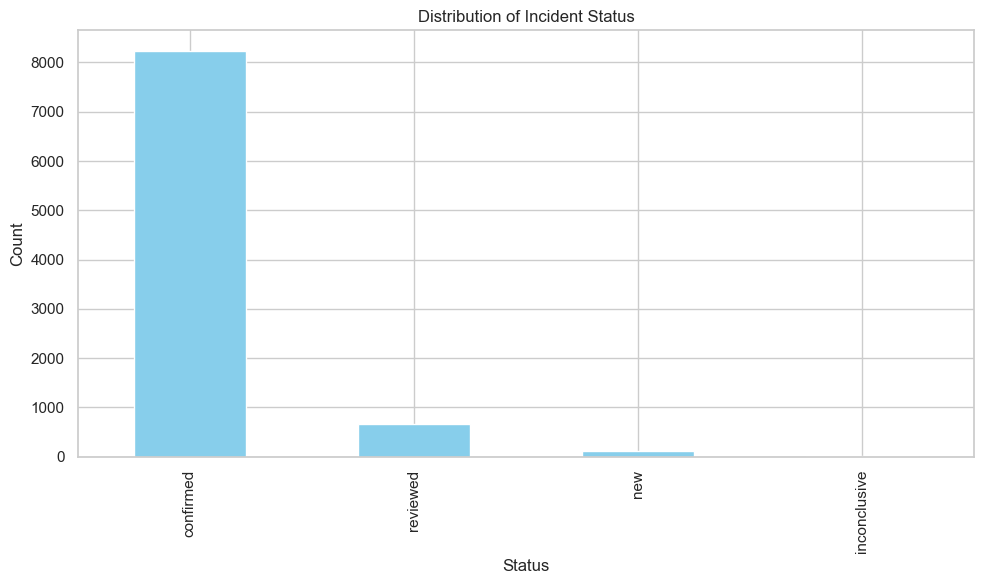

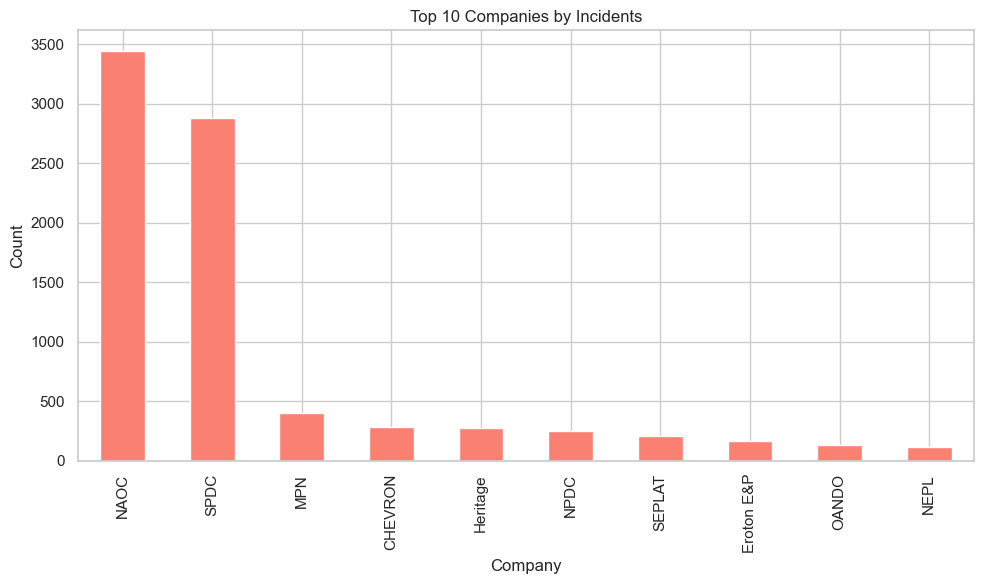

In [4]:
# Set visualization styles
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 1. Incident Status Distribution
df['status'].value_counts().plot(kind='bar', color='skyblue', title='Distribution of Incident Status')
plt.xlabel("Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. Top 10 Companies with Most Spills
df['company'].value_counts().head(10).plot(kind='bar', color='salmon', title='Top 10 Companies by Incidents')
plt.xlabel("Company")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

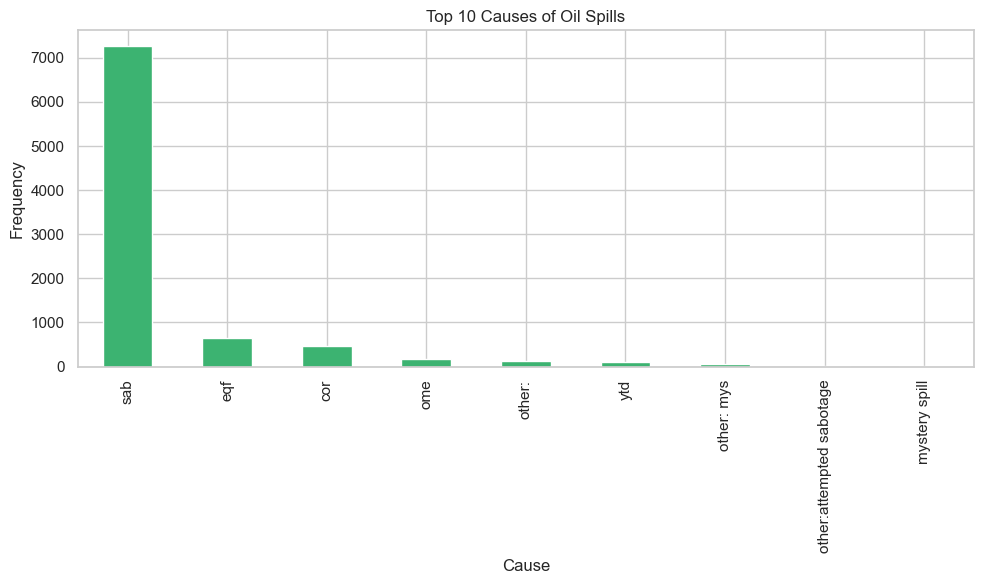

In [5]:
# 3. Top 10 Spill Causes
df['cause'].value_counts().head(10).plot(kind='bar', color='mediumseagreen', title='Top 10 Causes of Oil Spills')
plt.xlabel("Cause")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

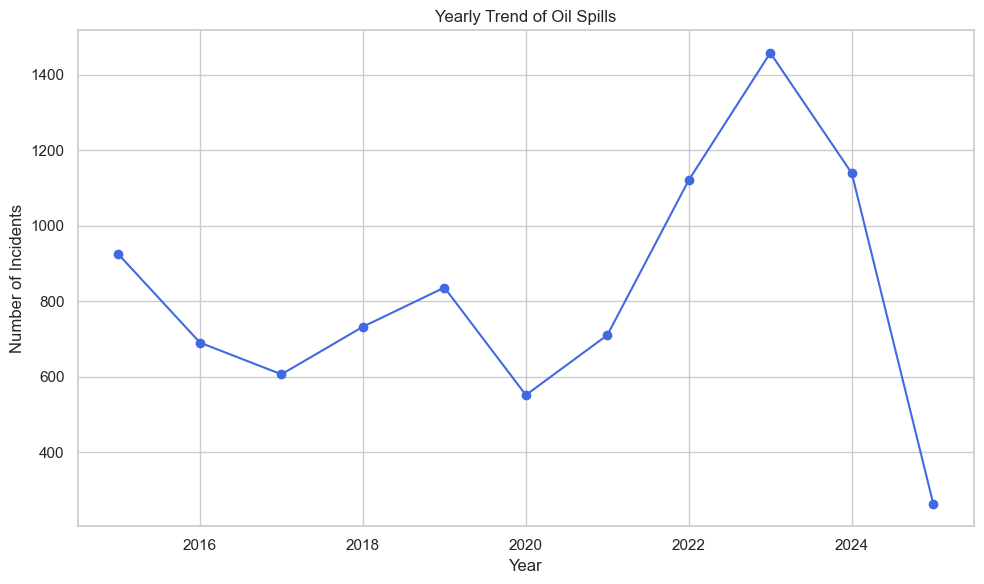

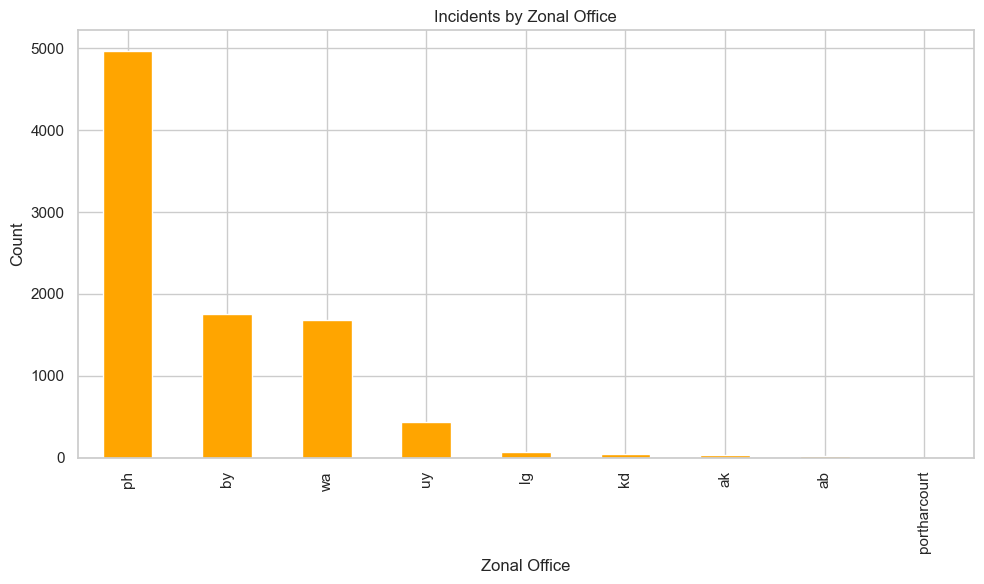

In [6]:
# 4. Yearly Trend of Incidents
df['year'] = df['incidentdate'].dt.year
df['year'].value_counts().sort_index().plot(marker='o', color='royalblue', title='Yearly Trend of Oil Spills')
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Incidents by Zonal Office (Cleaned)
df['zonaloffice_cleaned'] = df['zonaloffice'].str.lower().str.strip()
df['zonaloffice_cleaned'].value_counts().plot(kind='bar', color='orange', title='Incidents by Zonal Office')
plt.xlabel("Zonal Office")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [7]:
# Convert estimatedquantity to numeric (handle invalids as NaN)
df['estimatedquantity'] = pd.to_numeric(df['estimatedquantity'], errors='coerce')

# Define a threshold for severe spill — e.g., above median or 1.0
threshold = df['estimatedquantity'].median()

# Create target variable
df['severe_spill'] = df['estimatedquantity'].apply(lambda x: 1 if x >= threshold else 0)

# Check balance of classes
print(df['severe_spill'].value_counts())

severe_spill
0    5951
1    3079
Name: count, dtype: int64


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --------------------------------------------
# 1. Load and Clean Dataset
# --------------------------------------------

# Load CSV
df = pd.read_csv("nosdra.csv", on_bad_lines='skip')

# Convert estimatedquantity to numeric
df['estimatedquantity'] = pd.to_numeric(df['estimatedquantity'], errors='coerce')

# Create binary target: 1 if spill is severe, else 0
threshold = df['estimatedquantity'].median()
df['severe_spill'] = df['estimatedquantity'].apply(lambda x: 1 if x >= threshold else 0)

# Convert incidentdate to datetime and extract year
df['incidentdate'] = pd.to_datetime(df['incidentdate'], errors='coerce')
df['year'] = df['incidentdate'].dt.year

# Clean latitude and longitude values
def clean_coordinate(value):
    try:
        return float(str(value).strip().split()[-1])  # Remove 'N', 'E', etc.
    except:
        return None

df['latitude'] = df['latitude'].apply(clean_coordinate)
df['longitude'] = df['longitude'].apply(clean_coordinate)

# Drop rows with missing values in required fields
required_cols = ['company', 'cause', 'zonaloffice', 'typeoffacility', 'statesaffected', 'latitude', 'longitude', 'year', 'severe_spill']
df_model = df.dropna(subset=required_cols)

# --------------------------------------------
# 2. Feature Selection
# --------------------------------------------

X = df_model[['company', 'cause', 'zonaloffice', 'typeoffacility', 'statesaffected', 'latitude', 'longitude', 'year']]
y = df_model['severe_spill']

categorical_cols = ['company', 'cause', 'zonaloffice', 'typeoffacility', 'statesaffected']
numerical_cols = ['latitude', 'longitude', 'year']

# --------------------------------------------
# 3. Preprocessing & Modeling Pipeline
# --------------------------------------------

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # numeric columns pass through
)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# --------------------------------------------
# 4. Train-Test Split & Model Training
# --------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

# --------------------------------------------
# 5. Evaluation
# --------------------------------------------

print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1039
           1       0.59      0.58      0.59       556

    accuracy                           0.71      1595
   macro avg       0.69      0.68      0.68      1595
weighted avg       0.71      0.71      0.71      1595

📊 Confusion Matrix:
[[817 222]
 [233 323]]


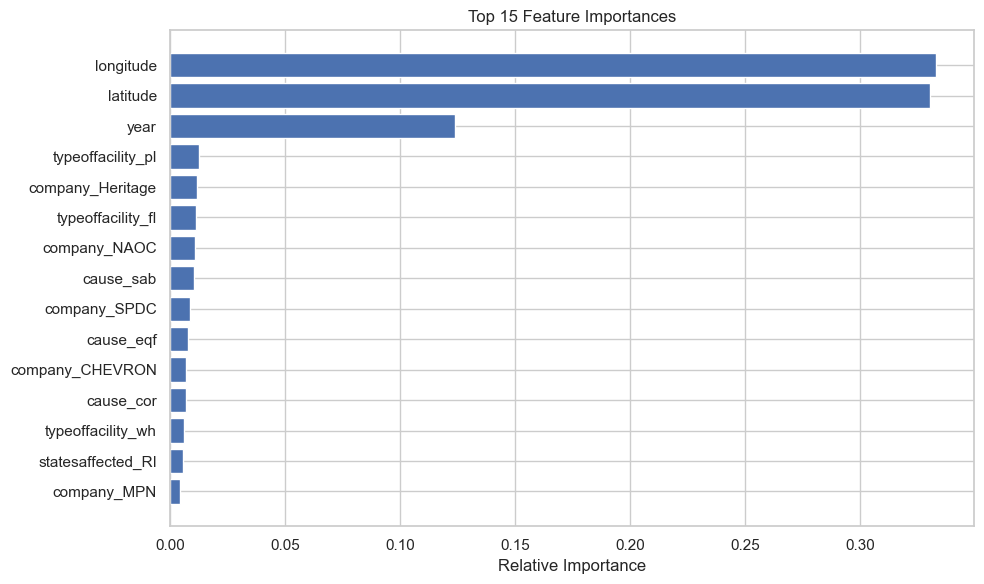

In [9]:
# Get feature names after encoding
ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_features = ohe.get_feature_names_out(categorical_cols)
all_features = list(encoded_cat_features) + numerical_cols

# Get feature importances
importances = model_pipeline.named_steps['classifier'].feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1]
top_n = 15  # show top 15 features

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances")
plt.barh(range(top_n), importances[indices[:top_n]][::-1], align='center')
plt.yticks(range(top_n), [all_features[i] for i in indices[:top_n]][::-1])
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

In [10]:
import re

def dms_to_decimal(dms):
    if isinstance(dms, str):
        # Remove direction letters and normalize separators
        dms = re.sub(r'[^\d:.]', '', dms.strip())
        parts = re.split(r'[:\s]', dms)
        parts = [float(p) for p in parts if p != '']
        if len(parts) == 3:
            degrees, minutes, seconds = parts
            return degrees + minutes/60 + seconds/3600
    return None


In [11]:
import pandas as pd
import re

# Load your CSV (handle bad lines)
df = pd.read_csv("nosdra.csv", engine='python', on_bad_lines='skip')

# Function to extract float from coordinate strings
def extract_first_float(text):
    if isinstance(text, str):
        match = re.search(r'\d+\.\d+', text)
        if match:
            return float(match.group(0))
    elif isinstance(text, (int, float)):
        return float(text)
    return None

# Clean latitude and longitude
df['latitude_clean'] = df['latitude'].apply(extract_first_float)
df['longitude_clean'] = df['longitude'].apply(extract_first_float)

# Drop rows with missing coordinates
df_cleaned = df.dropna(subset=['latitude_clean', 'longitude_clean'])

# Save the cleaned dataset
df_cleaned.to_csv("nosdra_cleaned.csv", index=False)


In [12]:
df_cleaned

,id,updatefor,status,zonaloffice,company,incidentnumber,incidentdate,reportdate,contaminant,estimatedquantity,...,remediationstart,remediationend,remediationtype,finalsamplingdate,finallabresultsdate,certificatedate,certificatenumber,lastupdatedby,latitude_clean,longitude_clean
0,24086,24086.0,confirmed,ph,NAOC,2015/Lar/003/004,2015-01-06,2015-01-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2015-01-09 PH045, 2015-02-22 PH002, 2015-03-20...",5.261139,6.563444
1,24091,24091.0,reviewed,ph,NAOC,2015/LAR/F1/001/001,2015-01-03,2015-01-05,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2015-01-10 PH067, 2015-02-22 PH002",5.095194,6.498389
2,24092,24092.0,confirmed,ph,NAOC,2015/LAR/001/001,2015-01-03,2015-01-05,co,0.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2015-01-10 PH067, 2015-02-03 PH067, 2015-02-22...",5.094361,6.459722
3,25382,25382.0,confirmed,uy,MPN,01/2015,2015-01-02,2015-01-06,cr,0.000411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2015-01-20 UY002, 2015-10-05 UY002",4.252246,8.228188
4,25383,25383.0,confirmed,uy,MPN,02/2015,2015-01-04,2015-01-06,cr,0.000016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2015-01-20 UY002, 2015-10-05 UY002, 2017-10-10...",4.252246,8.228188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9009,402362,NaN,new,uy,MPN,011 / 2025,2025-07-14,2025-07-15,cr,0.000001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-16 UY006,5.334722,2.168056
9010,402363,402363.0,reviewed,ph,SPDC,000174,2025-07-07,2025-07-07,nil,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2025-07-17 PH058, 2025-07-21 PH117",4.970776,6.639055
9011,402372,NaN,new,ph,NNPC EiGHTEEN OPERATING LIMITED (NEOL),2025/NEOL/CCOO46,2025-07-15,2025-07-15,cr,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-18 PH038,4.556556,7.012111
9012,402373,NaN,confirmed,wa,NEPL,NEPL/HSE/BAT/40/04/25,2025-06-14,2025-06-15,cr,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-19 WA006,5.806944,5.110833


In [13]:
# Load your CSV file
df = pd.read_csv("nosdra.csv", engine='python', on_bad_lines='skip')

# Clean coordinate fields
def extract_first_float(text):
    if isinstance(text, str):
        match = re.search(r'\d+\.\d+', text)
        if match:
            return float(match.group(0))
    elif isinstance(text, (int, float)):
        return float(text)
    return None

df['latitude_clean'] = df['latitude'].apply(extract_first_float)
df['longitude_clean'] = df['longitude'].apply(extract_first_float)

# Drop rows with missing coordinates
df_cleaned = df.dropna(subset=['latitude_clean', 'longitude_clean'])

# Create a folium map
m = folium.Map(location=[9.0820, 8.6753], zoom_start=6)  # Nigeria center
marker_cluster = MarkerCluster().add_to(m)

# Add markers
for _, row in df_cleaned.iterrows():
    folium.Marker(
        location=[row['latitude_clean'], row['longitude_clean']],
        popup=row.get('location', 'No location'),
        icon=folium.Icon(color='red', icon='tint', prefix='fa')
    ).add_to(marker_cluster)

# Save map
m.save("oil_spill_map.html")


In [14]:
print(df_cleaned[['latitude_clean', 'longitude_clean']].dropna().shape)


(8668, 2)


In [15]:

# Function to extract the first valid float (for coordinates)
def extract_first_float(text):
    if isinstance(text, str):
        match = re.search(r'\d+\.\d+', text)
        if match:
            return float(match.group(0))
    elif isinstance(text, (int, float)):
        return float(text)
    return None

# Apply to latitude and longitude
df['latitude_clean'] = df['latitude'].apply(extract_first_float)
df['longitude_clean'] = df['longitude'].apply(extract_first_float)

# Check how many rows have valid coordinates
print(df[['latitude_clean', 'longitude_clean']].dropna().shape)

# Save cleaned file
df.dropna(subset=['latitude_clean', 'longitude_clean']).to_csv("nosdra_cleaned.csv", index=False)


(8668, 2)


In [16]:
# Create a folium map
m = folium.Map(location=[9.0820, 8.6753], zoom_start=6)  # Nigeria center
marker_cluster = MarkerCluster().add_to(m)

# Add markers
for _, row in df_cleaned.iterrows():
    folium.Marker(
        location=[row['latitude_clean'], row['longitude_clean']],
        popup=row.get('location', 'No location'),
        icon=folium.Icon(color='red', icon='tint', prefix='fa')
    ).add_to(marker_cluster)

# Save map
m.save("oil_spill_map.html")

In [17]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster, HeatMap

# Load cleaned data
df = pd.read_csv("nosdra_cleaned.csv")

# Convert estimatedquantity to numeric
df['estimatedquantity'] = pd.to_numeric(df['estimatedquantity'], errors='coerce')

# Drop rows with missing coordinates or quantity
df = df.dropna(subset=['latitude_clean', 'longitude_clean', 'estimatedquantity'])

# Initialize base map
m = folium.Map(location=[9.0820, 8.6753], zoom_start=6)

# Add marker cluster
marker_cluster = MarkerCluster().add_to(m)

# Function to determine marker color based on volume
def get_color(volume):
    if volume < 10:
        return 'green'
    elif 10 <= volume < 100:
        return 'orange'
    else:
        return 'red'

# Add color-coded markers
for _, row in df.iterrows():
    lat, lon = row['latitude_clean'], row['longitude_clean']
    volume = row['estimatedquantity']
    location = row.get('location', 'Unknown Location')

    color = get_color(volume)

    folium.Marker(
        location=[lat, lon],
        popup=f"<b>Location:</b> {location}<br><b>Volume:</b> {volume} barrels",
        icon=folium.Icon(color=color, icon='tint', prefix='fa')
    ).add_to(marker_cluster)

# Optional: Add Heatmap layer for high-density spill areas
heat_data = df[['latitude_clean', 'longitude_clean']].values.tolist()
HeatMap(heat_data).add_to(m)

# Save map
m.save("enhanced_oil_spill_map.html")
print("✅ Enhanced map saved as enhanced_oil_spill_map.html")


✅ Enhanced map saved as enhanced_oil_spill_map.html


ADF Statistic: -11.290588660660674
p-value: 1.3829899710757013e-20


C:\Users\Gaxton\AppData\Local\Temp\ipykernel_10780\4137029717.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast.index = pd.date_range(
C:\Users\Gaxton\AppData\Local\Temp\ipykernel_10780\4137029717.py:52: UserWarning: Glyph 128738 (\N{OIL DRUM}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Gaxton\AppData\Local\Temp\ipykernel_10780\4137029717.py:52: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Gaxton\AppData\Local\Temp\ipykernel_10780\4137029717.py:53: UserWarning: Glyph 128738 (\N{OIL DRUM}) missing from font(s) Arial.
  plt.savefig("oil_spill_forecast.png")
C:\Users\Gaxton\AppData\Local\Temp\ipykernel_10780\4137029717.py:53: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig("oil_spill_forecast.png")
C:\Users\Gaxton\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12873

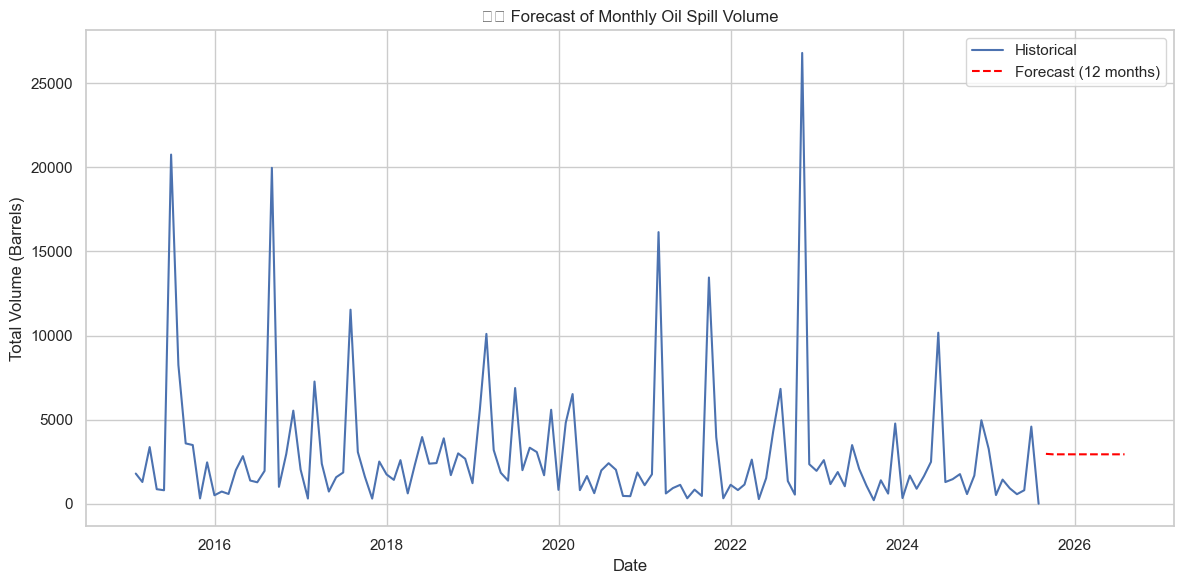

Forecast done


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# 1. Load dataset
df = pd.read_csv("nosdra_cleaned.csv")

# 2. Parse dates
df['incidentdate'] = pd.to_datetime(df['incidentdate'], errors='coerce')

# 3. Convert estimatedquantity to numeric
df['estimatedquantity'] = pd.to_numeric(df['estimatedquantity'], errors='coerce')

# 4. Drop missing or invalid values
df = df.dropna(subset=['incidentdate', 'estimatedquantity'])
df = df[df['estimatedquantity'] > 0]

# 5. Monthly aggregation
monthly_spills = df.set_index('incidentdate').resample('ME').agg({
    'estimatedquantity': 'sum'
}).rename(columns={'estimatedquantity': 'total_volume'})

# 6. Save cleaned monthly data
monthly_spills.to_csv("monthly_spill_volume.csv")

# 7. ADF test (optional stationarity check)
result = adfuller(monthly_spills['total_volume'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# 8. Fit ARIMA model
model = ARIMA(monthly_spills['total_volume'], order=(1, 1, 1))
model_fit = model.fit()

# 9. Forecast next 12 months
forecast = model_fit.forecast(steps=12)
forecast.index = pd.date_range(
    start=monthly_spills.index[-1] + pd.DateOffset(months=1),
    periods=12, freq='M'
)

# 10. Plot results
plt.figure(figsize=(12, 6))
plt.plot(monthly_spills['total_volume'], label='Historical')
plt.plot(forecast, label='Forecast (12 months)', linestyle='--', color='red')
plt.title("🛢️ Forecast of Monthly Oil Spill Volume")
plt.xlabel("Date")
plt.ylabel("Total Volume (Barrels)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("oil_spill_forecast.png")
plt.show()
print('Forecast done')